In [17]:
import os
import zipfile
import shutil
import glob
import netCDF4 as nc
from netCDF4 import Dataset
import rasterio
import rasterio.mask
from rasterio.transform import from_origin
import numpy as np
from osgeo import gdal, osr
import xarray as xr
import dask
import rioxarray as rio
import matplotlib
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import pandas as pd
import pyproj
import shapefile
from shapely.geometry import shape
import rasterio.mask
import fiona

In [44]:
# Add lat/lon as spatial dimensions to TSM netcdf from geo_coordinates netcdf

# **Step 1: Open the NetCDF files**
tsm_nc = "/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/tsm_nn.nc"  # NetCDF with data but missing lat/lon dimensions
geocoord_nc = "/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/geo_coordinates.nc"  # NetCDF containing lat/lon dimensions

ds_tsm = xr.open_dataset(tsm_nc)
ds_geocoord = xr.open_dataset(geocoord_nc)

# **Step 2: Extract latitude & longitude**
lat = ds_geocoord["latitude"].values  # Extract lat as NumPy array
lon = ds_geocoord["longitude"].values  # Extract lon as NumPy array

# **Step 3: Ensure lat/lon are correctly formatted**
if lat.ndim == 2:  # If 2D, extract unique values along the correct axis
    lat = lat[:, 0]  # Take the first column (assuming lat is constant across rows)
if lon.ndim == 2:
    lon = lon[0, :]  # Take the first row (assuming lon is constant across columns)

print(f"Latitude shape after fix: {lat.shape}")  # Should be (4289,)
print(f"Longitude shape after fix: {lon.shape}")  # Should be (4481,)

# **Step 4: Extract Data & Ensure Correct Shape**
var_name = list(ds_tsm.data_vars.keys())[0]  # Get first variable name
data_values = ds_tsm[var_name].values  # Extract data

# If data is 3D (e.g., time, lat, lon), select the first time step
if data_values.ndim == 3:
    data_values = data_values[0, :, :]

# Ensure the data shape matches (lat, lon)
if data_values.shape != (len(lat), len(lon)):
    raise ValueError(
        f"Mismatch: data shape {data_values.shape} vs expected ({len(lat)}, {len(lon)})"
    )

print(f"Final Data shape: {data_values.shape}")  # Should match (4289, 4481)

# **Step 5: Create a new NetCDF dataset with correct dimensions**
ds_new = xr.Dataset(
    {
        var_name: (["latitude", "longitude"], data_values)
    },
    coords={
        "latitude": ("latitude", lat),  # Assign dimensions explicitly
        "longitude": ("longitude", lon)
    }
)

# **Step 6: Save the updated dataset**
tsm_nc_spdm = "/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/tsm_nn_spdm.nc"
ds_new.to_netcdf(tsm_nc_spdm)

Latitude shape after fix: (4289,)
Longitude shape after fix: (4481,)
Final Data shape: (4289, 4481)


In [45]:
#  Assign CRS to modified TSM netcdf with lat/lon as dimensions

# Open the NetCDF file
dataset = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/tsm_nn_spdm.nc", decode_coords="all")

# Assign the CRS using the EPSG code
dataset.rio.write_crs("EPSG:4326", inplace=True)

# Save the modified dataset
dataset.to_netcdf("/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/tsm_nn_spdm_crs.nc")

In [48]:
# Open TSM NetCDF file with lat/lon as dimensions
tsm_nc_spdm_view = xr.open_dataset("/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/tsm_nn_spdm.nc")
tsm_nc_spdm_view

<xarray.Dataset> Size: 77MB
Dimensions:    (latitude: 4289, longitude: 4481)
Coordinates:
  * latitude   (latitude) float64 34kB nan nan nan nan nan ... nan nan nan nan
  * longitude  (longitude) float64 36kB nan nan nan nan nan ... nan nan nan nan
Data variables:
    TSM_NN     (latitude, longitude) float32 77MB ...

In [ ]:
# https://help.marine.copernicus.eu/en/articles/5029956-how-to-convert-netcdf-to-geotiff

nc_file = xr.open_dataset('/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/tsm_nn_spdm.nc')
nc_file

tsm = nc_file['TSM_NN']

tsm = tsm.rio.set_spatial_dims(x_dim='longitude', y_dim='latitude')
tsm.rio.crs

# Define the CRS projection
tsm.rio.write_crs("epsg:4326", inplace=True)

tsm.rio.to_raster(r"/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/tsm_nn_bad.tif")

In [ ]:
# Plot TSM geotiff

def view_geotiff(file_path):
    """
    Opens and displays a GeoTIFF file, handling NaN/Inf values properly.

    :param file_path: Path to the GeoTIFF file
    """
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(np.float32)  # Read the first band and ensure float32

        # Handle NoData values
        if src.nodata is not None:
            data[data == src.nodata] = np.nan  # Convert NoData to NaN

        # Check if all values are NaN
        if np.all(np.isnan(data)):
            raise ValueError(f"Error: The dataset {file_path} contains only NaN values and cannot be plotted.")

        # Ensure valid extent
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        # Check if extent contains NaN or Inf
        if any(np.isnan(extent)) or any(np.isinf(extent)):
            raise ValueError(f"Error: The spatial extent contains NaN/Inf values: {extent}")

        # Mask invalid values for plotting
        data = np.ma.masked_invalid(data)

        # Plot the data
        plt.figure(figsize=(10, 6))
        plt.imshow(data, cmap="viridis", extent=extent, origin="upper")
        plt.colorbar(label="Value")
        plt.title(f"GeoTIFF Visualization: {file_path}")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()

# Example Usage
if __name__ == "__main__":
    tsm_tif_fix = "/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/tsm_nn_bad.tif"  
    view_geotiff(tsm_tif_fix)

ValueError: Error: The spatial extent contains NaN/Inf values: [nan, nan, nan, nan]

In [ ]:
# Plot netcdf 


# Define file path
netcdf_file = "/Users/lopezama/Documents/Blackwood/MERIS/scripts/earth_data/script_testing/test_data/20120407T182444/tsm_nn_spdm_crs.nc"

# Open NetCDF file
ds = xr.open_dataset(netcdf_file)

# Define variable names (modify as needed)
data_var_name = "TSM_NN"  # Change to your variable name
lat_name = "latitude"  # Change to actual latitude variable name
lon_name = "longitude"  # Change to actual longitude variable name

# Extract data, latitude, and longitude
data = ds[data_var_name].values
lat = ds[lat_name].values
lon = ds[lon_name].values

# Ensure data is 2D (select first time step if 3D)
if data.ndim == 3:
    data = data[0, :, :]

# Convert 1D lat/lon to 2D meshgrid if necessary
if lat.ndim == 1 and lon.ndim == 1:
    lon, lat = np.meshgrid(lon, lat)

# Handle missing values
if np.isnan(data).all():
    raise ValueError("Error: The dataset contains only NaN values!")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Plot data using pcolormesh
img = ax.pcolormesh(lon, lat, data, cmap="viridis", shading="auto", transform=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")
ax.add_feature(cfeature.LAND, color="lightgray", alpha=0.5)
ax.add_feature(cfeature.OCEAN, color="lightblue", alpha=0.3)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linestyle="--", color="gray")
gl.top_labels = False
gl.right_labels = False

# Add colorbar
cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
cbar.set_label(data_var_name)

# Show plot
plt.title(f"{data_var_name} from NetCDF")
plt.show()

In [11]:
# Fix bounding box and transform in geotiff

####### Western US ROI bounding box

# Min lat (South): 32.4
# Max lat (North) 48.6
# Min lon (West): -125.2
# Max lon (East): -116.8

#######

def fix_geotiff(file_path, output_path):
    """
    Fixes the GeoTIFF file by manually setting the transform and CRS.
    
    :param file_path: Path to the GeoTIFF file
    :param output_path: Path to save the fixed GeoTIFF
    """
    with rasterio.open(file_path) as src:
        # Read the data
        data = src.read(1).astype(np.float32)

        # Define the bounding box (min_lon, max_lon, min_lat, max_lat)
        min_lon = -125.2  # Set your correct min longitude
        max_lon = -116.8   # Set your correct max longitude
        min_lat = 32.4   # Set your correct min latitude
        max_lat = 48.6    # Set your correct max latitude

        # Define the transform (top-left corner, pixel size)
        # from_origin(top_left_x, top_left_y, pixel_width, pixel_height)
        transform = from_origin(min_lon, max_lat, (max_lon - min_lon) / data.shape[1], (max_lat - min_lat) / data.shape[0])

        # Set the CRS (assuming WGS84 - EPSG:4326)
        crs = "EPSG:4326"

        # Write the fixed GeoTIFF
        with rasterio.open(output_path, 'w', driver='GTiff', 
                           count=1, dtype=data.dtype, 
                           crs=crs, transform=transform, 
                           width=data.shape[1], height=data.shape[0]) as dst:
            dst.write(data, 1)

# Example Usage
tif_bad = "/Users/lopezama/Documents/Blackwood/MERIS/download_test/data/20120401T184126_use/tsm_nn_bad.tif"
tif_fix = "/Users/lopezama/Documents/Blackwood/MERIS/download_test/data/20120401T184126_use/tsm_nn_fix.tif"
fix_geotiff(tif_bad, tif_fix)

✅ Clipped raster saved to: /Users/lopezama/Documents/Blackwood/MERIS/download_test/data/20120401T184126_use/tsm_nn_fix_clip_test.tif


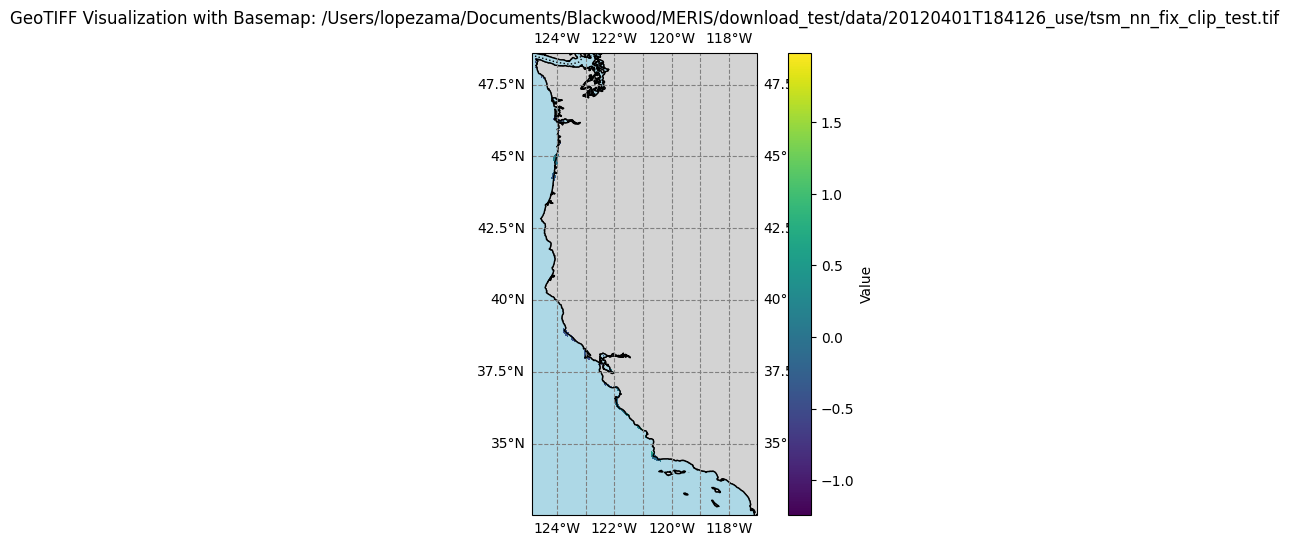

In [ ]:
# NEW Clip to ROI using shapefile - start using this instead of old way

def clip_raster_with_shapefile(raster_path, shapefile_path, output_path, nodata_value=None):
    """
    Clips a raster using a shapefile and preserves NoData values.
    
    :param raster_path: Path to input raster file.
    :param shapefile_path: Path to shapefile.
    :param output_path: Path to save the clipped raster.
    :param nodata_value: NoData value to assign (if None, keeps original NoData).
    """
    with rasterio.open(raster_path) as src:
        # Read geometry from shapefile
        with fiona.open(shapefile_path, "r") as shapefile:
            shapes = [feature["geometry"] for feature in shapefile]

        # Clip raster
        clipped_image, clipped_transform = rasterio.mask.mask(src, shapes, crop=True, nodata=nodata_value)
        clipped_meta = src.meta.copy()

        # Update metadata
        clipped_meta.update({
            "height": clipped_image.shape[1],
            "width": clipped_image.shape[2],
            "transform": clipped_transform,
            "nodata": nodata_value if nodata_value is not None else src.nodata
        })

        # Save the clipped raster
        with rasterio.open(output_path, "w", **clipped_meta) as dst:
            dst.write(clipped_image)

    print(f"✅ Clipped raster saved to: {output_path}")



# Example Usage
clip_raster_with_shapefile(
    raster_path="/Users/lopezama/Documents/Blackwood/MERIS/download_test/data/20120401T184126_use/tsm_nn_fix.tif",
    shapefile_path="/Users/lopezama/Documents/Blackwood/MERIS/ROI/west_us_poly/west_us_poly.shp",
    output_path="/Users/lopezama/Documents/Blackwood/MERIS/download_test/data/20120401T184126_use/tsm_nn_fix_clip_test.tif",
    nodata_value=np.nan  # Ensure NoData values are preserved
)

# TEST Plot clipped TSM geotiff with basemap

def view_geotiff_with_basemap(file_path):
    """
    Opens and displays a GeoTIFF file with a basemap, handling NaN/Inf values properly.

    :param file_path: Path to the GeoTIFF file
    """
    with rasterio.open(file_path) as src:
        # Read data
        data = src.read(1).astype(np.float32)  

        # Handle NoData values
        if src.nodata is not None:
            data[data == src.nodata] = np.nan  

        # Check if all values are NaN
        if np.all(np.isnan(data)):
            raise ValueError(f"Error: The dataset {file_path} contains only NaN values and cannot be plotted.")

        # Compute extent
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

        # Mask invalid values
        data = np.ma.masked_invalid(data)

        # Create plot with Cartopy projection
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})

        # Add basemap features
        ax.set_extent(extent, crs=ccrs.PlateCarree())  # Ensure correct extent
        ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Land feature
        ax.add_feature(cfeature.OCEAN, facecolor='lightblue')  # Ocean feature
        ax.add_feature(cfeature.BORDERS, linestyle=":")  # Country borders
        ax.add_feature(cfeature.COASTLINE, edgecolor="black")  # Coastline
        ax.gridlines(draw_labels=True, linestyle="--", color="gray")

        # Plot the raster data
        img = ax.imshow(data, cmap="viridis", extent=extent, origin="upper", transform=ccrs.PlateCarree())

        # Add colorbar
        cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=0.03, pad=0.04)
        cbar.set_label("Value")

        # Set title
        plt.title(f"GeoTIFF Visualization with Basemap: {file_path}")

        # Show the plot
        plt.show()

# Example Usage
clip = '/Users/lopezama/Documents/Blackwood/MERIS/download_test/data/20120401T184126_use/tsm_nn_fix_clip_test.tif'
view_geotiff_with_basemap(clip)